In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import cv2

In [3]:
data_df = pd.read_csv('../../../data/sixth_df_input.csv')

In [3]:
final_model = {'max_depth': 10, 'min_sample_split': 2, 'min_sample_leaf': 15, 'max_features': 'sqrt'}

In [7]:
data_df = pd.read_csv('../../../data/sixth_df_input.csv')

data_df['Rank'] = data_df['Rank'].astype('int')
data_df.head()


dict_map_sex = {'men': 1, 'women': 0}
data_df['sex'] = data_df['sex'].map(dict_map_sex)

dict_map_format = {'sprint' : 0, 'pursuit': 1, 'individual': 2, 'mass_start': 3, 'sprint_2': 0, 'pursuit_2': 1}
data_df['format'] = data_df['format'].map(dict_map_format)

def rank_transform(x):
    if x == 1:
        return 0
    elif x == 2 or x == 3:
        return 1
    elif x > 3:
        return 2

data_df['Rank'] = data_df['Rank'].apply(rank_transform)

final_df = data_df[['season', 'Rank', 'distance', 'Behind', 'format', 'position', 'km_to_go', 'standing_remaining', 'prone_remaining', 'probability_standing',\
    'probability_prone', 'back_from_median', 'gradient_back', 'all_mistakes_prone', 'all_mistakes_standing', 'gradient_standing', 'gradient_prone',\
        'gradient_pos', 'behind_above', 'behind_below', 'standing_above', 'standing_below', 'prone_above', 'prone_below']]

final_df_train = final_df[final_df['season'] != '2021-2022']
final_df_test = final_df[final_df['season'] == '2021-2022']

final_df_train = final_df_train.drop(['season'], axis = 1)
final_df_test = final_df_test.drop(['season'], axis = 1)


weights = sklearn.utils.class_weight.compute_class_weight('balanced', classes = np.unique(final_df_train['Rank']), y = final_df_train['Rank'])

weights_dict = {'0': weights[0], '1': weights[1], '2': weights[2]}

final_df_test = final_df_test.drop(columns = ['distance'])
final_df_train = final_df_train.drop(columns = ['distance'])

In [5]:
RF_clf_final = RandomForestClassifier(max_depth=final_model['max_depth'], class_weight =  weights_dict, n_estimators=100,\
            random_state=0, min_samples_leaf = final_model['min_sample_leaf'], min_samples_split = final_model['min_sample_split'],\
                max_features = final_model['max_features'])

RF_clf_final.fit(final_df_train.iloc[:,1:], final_df_train.iloc[:,0].astype(str))


train_err = 1 - RF_clf_final.score(final_df_train.iloc[:,1:], final_df_train.iloc[:,0].astype(str),\
     sample_weight = final_df_train['Rank'].astype(str).map(weights_dict))
print("Training error = %1.3f" % train_err)
test_err = 1 - RF_clf_final.score(final_df_test.iloc[:,1:], final_df_test.iloc[:,0].astype(str),\
     sample_weight = final_df_test['Rank'].astype(str).map(weights_dict))
print("Test error = %1.3f" % test_err)

# display features importances
display(pd.DataFrame(data=np.array([RF_clf_final.feature_names_in_, RF_clf_final.feature_importances_]).T,
                     columns=["feature names", "feature importance"]).sort_values(by='feature importance', ascending=False))

Training error = 0.117
Test error = 0.267


,feature names,feature importance
16,behind_below,0.190856
2,position,0.126947
18,standing_below,0.126026
20,prone_below,0.123482
0,Behind,0.102859
8,back_from_median,0.100237
19,prone_above,0.025772
3,km_to_go,0.024428
17,standing_above,0.022532
6,probability_standing,0.020522


In [4]:
import joblib

#joblib.dump(RF_clf_final, '../../../final_model.joblib')
RF_clf_final = joblib.load('../../../final_model.joblib')

In [5]:
columns_input = ['season', 'Rank', 'Behind', 'format', 'position', 'km_to_go', 'standing_remaining', 'prone_remaining', 'probability_standing',\
    'probability_prone', 'back_from_median', 'gradient_back', 'all_mistakes_prone', 'all_mistakes_standing', 'gradient_standing', 'gradient_prone',\
        'gradient_pos', 'behind_above', 'behind_below', 'standing_above', 'standing_below', 'prone_above', 'prone_below']

In [8]:
df_predictions = pd.DataFrame(RF_clf_final.predict_proba(final_df_test.iloc[:,1:]), columns = ['Victory', '2-3_place', 'no_podium'])

In [9]:
df_predictions['Podium'] = df_predictions['Victory'] + df_predictions['2-3_place']
df_predictions

,Victory,2-3_place,no_podium,Podium
0,0.602190,0.346266,0.051543,0.948457
1,0.618450,0.332175,0.049375,0.950625
2,0.618391,0.292577,0.089032,0.910968
3,0.635909,0.292506,0.071585,0.928415
4,0.455118,0.446033,0.098849,0.901151
...,...,...,...,...
59728,0.000000,0.001231,0.998769,0.001231
59729,0.000000,0.000038,0.999962,0.000038
59730,0.000000,0.000038,0.999962,0.000038
59731,0.000010,0.000284,0.999706,0.000294


In [10]:
data_df_test = data_df[data_df['season'] == '2021-2022']
data_df_test.reset_index(inplace = True)
data_df_test_prob = pd.merge(data_df_test, df_predictions, left_index = True, right_index = True)

In [11]:
data_df_test_prob[data_df_test_prob['Rank'] > 0 ].sort_values(by = 'Victory', ascending = False).head(20)


,index,full_name,distance,Rank,sex,Behind,format,season,date,date_order,...,behind_above,behind_below,standing_above,standing_below,prone_above,prone_below,Victory,2-3_place,no_podium,Podium
7693,135807,Hanna_Sola,9.2,1,0,0.0,1,2021-2022,2021-12-12,177.0,...,1874.928213,0.0,14.884839,0.0,15.683111,0.0,0.957899,0.041543,0.000558,0.999442
7750,135864,Hanna_Sola,9.6,1,0,0.0,1,2021-2022,2021-12-12,177.0,...,1817.629564,0.0,14.863393,0.0,15.655806,0.0,0.956991,0.042451,0.000558,0.999442
7636,135750,Hanna_Sola,8.0,1,0,0.0,1,2021-2022,2021-12-12,177.0,...,1930.895998,0.0,14.886185,0.0,15.702070,0.0,0.955876,0.043536,0.000588,0.999412
28686,156800,Marte Olsbu_Roeiseland,7.3,1,0,0.0,1,2021-2022,2022-03-19,203.0,...,2386.039655,0.0,14.362880,0.0,15.436189,0.0,0.938120,0.059750,0.002130,0.997870
28633,156747,Marte Olsbu_Roeiseland,6.6,1,0,0.0,1,2021-2022,2022-03-19,203.0,...,2346.538689,0.0,14.358838,0.0,15.434709,0.0,0.928083,0.069157,0.002760,0.997240
3697,131811,Hanna_Sola,3.8,1,0,0.0,0,2021-2022,2021-12-02,172.0,...,539.734501,0.0,14.632990,0.0,16.703991,0.0,0.917837,0.076066,0.006096,0.993904
3810,131924,Hanna_Sola,4.2,1,0,0.0,0,2021-2022,2021-12-02,172.0,...,565.309968,0.0,14.670261,0.0,16.666378,0.0,0.917093,0.076814,0.006093,0.993907
3584,131698,Hanna_Sola,3.4,1,0,0.0,0,2021-2022,2021-12-02,172.0,...,504.433169,0.0,14.586020,0.0,16.752513,0.0,0.914957,0.078473,0.006571,0.993429
3923,132037,Hanna_Sola,4.6,1,0,0.0,0,2021-2022,2021-12-02,172.0,...,589.029995,0.0,14.672052,0.0,16.645263,0.0,0.914936,0.079115,0.005949,0.994051
5239,133353,Anais_Chevalier-Bouchet,8.0,1,0,0.0,1,2021-2022,2021-12-04,173.0,...,1553.811092,0.0,15.151633,0.0,15.849512,0.0,0.913590,0.081350,0.005060,0.994940


In [12]:
def formatter(x, pos):
    del pos
    return f'{x*100:.2f}%'

In [13]:
10/4

2.5

In [14]:
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
def add_ax(fig, ax, n_shooting_total, shooting_number):
    ax_ = fig.add_axes([0.1, 0.1, 0.1, 0.1])
    left, bottom, width, height = (1/5) - 0.15/2, -0.3, 0.15, 0.15#((1 * shooting_number)/(n_shooting_total) + 1) - 0.15/2, -0.3, 0.15, 0.15
    ip = InsetPosition(ax, [left, bottom, width, height])
    ax_.set_axes_locator(ip)
    ax_.axis('off')
    return ax_

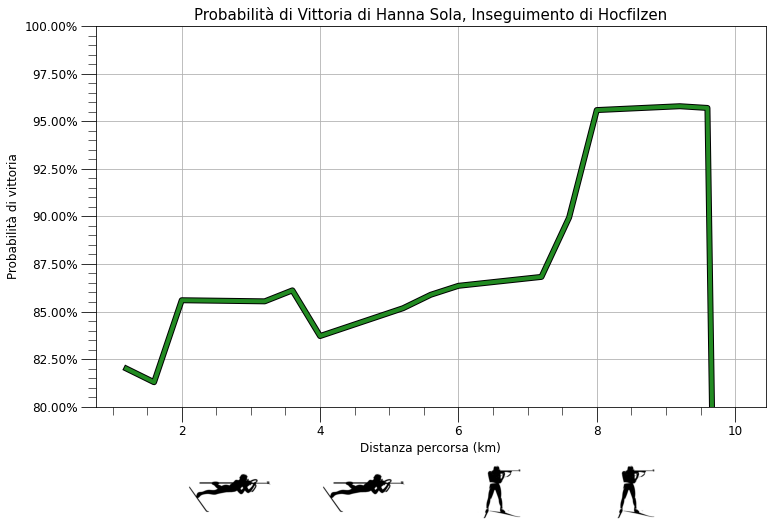

In [35]:

df_Sola = data_df_test_prob[data_df_test_prob.full_name == 'Hanna_Sola']
df_collapse = df_Sola[df_Sola.date_order == 177.0]

im = plt.imread('../../../prone.png')
im_stand = plt.imread('../../../standing.png')

fig, ax = plt.subplots(figsize=(12 ,7))
ax.plot(list(df_collapse['distance']) + [10], list(df_collapse['Victory']) + [0], color = 'forestgreen', linewidth = 4, zorder = 3)
ax.plot(list(df_collapse['distance']) + [10], list(df_collapse['Victory']) + [0], color = 'black', linewidth = 6, zorder = 2)
ax.grid(zorder = 1)
ax.set_ylim(0.8, 1)
ax.tick_params(axis='both', which='major', labelsize=12, length=15)
ax.tick_params(axis='both', which='minor', labelsize=12, length=8)
ax.minorticks_on()
ax.set_xlabel('Distanza percorsa (km)', fontsize = 12)
ax.set_ylabel('Probabilità di vittoria', fontsize = 12)
ax.yaxis.set_major_formatter(formatter)
ax.set_title('Probabilità di Vittoria di Hanna Sola, Inseguimento di Hocfilzen', fontsize = 15)

left, bottom, width, height = (1/5) - 0.15/2, -0.3, 0.15, 0.15
ip = InsetPosition(ax, [left, bottom, width, height])
print(ip)


for i in range(1, 3):
    left, bottom, width, height = ((1 * i)/5) - 0.15/2, -0.3, 0.15, 0.15
    ip = InsetPosition(ax, [left, bottom, width, height])

    new_ax1 = fig.add_axes([0.1, 0.1, 0.1, 0.1], zorder = 4)
    new_ax1.imshow(im)
    new_ax1.set_axes_locator(ip)
    new_ax1.axis('off')


for i in range(3, 5):
    left, bottom, width, height = ((1 * i)/5) - 0.15/2, -0.3, 0.15, 0.15
    ip = InsetPosition(ax, [left, bottom, width, height])

    new_ax1 = fig.add_axes([0.1, 0.1, 0.1, 0.1], zorder = 4)
    new_ax1.imshow(im_stand)
    new_ax1.set_axes_locator(ip)
    new_ax1.axis('off')


plt.show()
#plt.savefig('/Users/tommaso/Desktop/tmp/Sola_Oestersund.png', dpi = 300)
#ax.yaxis.set_major_formatter(mtick.PercentFormatter())

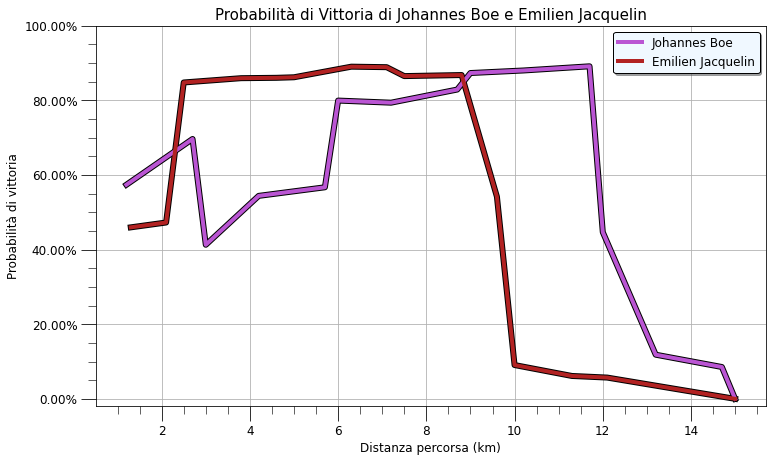

In [16]:
df_Boe = data_df_test_prob[data_df_test_prob.full_name == 'Johannes Thingnes_Boe']
df_collapse_Boe = df_Boe[df_Boe.date_order == 189.0]
df_Jac = data_df_test_prob[data_df_test_prob.full_name == 'Emilien_Jacquelin']
df_collapse_Jac = df_Jac[df_Jac.date_order == 174.0]
fig, ax = plt.subplots(figsize=(12 ,7))
ax.plot(list(df_collapse_Boe['distance']) + [15], list(df_collapse_Boe['Victory']) + [0], color = 'mediumorchid', linewidth = 4, zorder = 3, label = 'Johannes Boe')
ax.plot(list(df_collapse_Boe['distance']) + [15], list(df_collapse_Boe['Victory']) + [0], color = 'black', linewidth = 6, zorder = 2)
ax.plot(list(df_collapse_Jac['distance']) + [15], list(df_collapse_Jac['Victory']) + [0], color = 'firebrick', linewidth = 4, zorder = 3, label = 'Emilien Jacquelin')
ax.plot(list(df_collapse_Jac['distance']) + [15], list(df_collapse_Jac['Victory']) + [0], color = 'black', linewidth = 6, zorder = 2)
ax.grid(zorder = 1)
ax.set_ylim(-0.02, 1)
ax.tick_params(axis='both', which='major', labelsize=12, length=15)
ax.tick_params(axis='both', which='minor', labelsize=12, length=8)
ax.minorticks_on()
ax.set_xlabel('Distanza percorsa (km)', fontsize = 12)
ax.set_ylabel('Probabilità di vittoria', fontsize = 12)
ax.yaxis.set_major_formatter(formatter)
ax.set_title('Probabilità di Vittoria di Johannes Boe e Emilien Jacquelin', fontsize = 15)
ax.legend(fontsize = 12, facecolor = 'aliceblue', shadow = True, edgecolor = 'black')
plt.show()
#plt.savefig('/Users/tommaso/Desktop/tmp/Boe_Jac.png', dpi = 300)



#ax.yaxis.set_major_formatter(mtick.PercentFormatter())

In [17]:
data_df_test_prob[data_df_test_prob['Rank'] > 1 ].sort_values(by = 'Podium', ascending = False).head(20)

,index,full_name,distance,Rank,sex,Behind,format,season,date,date_order,...,behind_above,behind_below,standing_above,standing_below,prone_above,prone_below,Victory,2-3_place,no_podium,Podium
30686,295385,Vetle Sjaastad_Christiansen,14.4,2,1,0.0,2,2021-2022,2021-11-27,170.0,...,2051.987316,0.0,16.738281,0.0,17.513644,0.0,0.850604,0.144299,0.005097,0.994903
20750,148864,Dzinara_Alimbekava,11.6,2,0,0.0,2,2021-2022,2022-02-07,191.0,...,2244.886045,0.0,15.176827,0.0,16.523136,0.0,0.897364,0.097054,0.005582,0.994418
20578,148692,Dzinara_Alimbekava,10.3,2,0,0.0,2,2021-2022,2022-02-07,191.0,...,2228.164790,0.0,15.202490,0.0,16.532981,0.0,0.898365,0.095973,0.005662,0.994338
20664,148778,Dzinara_Alimbekava,10.9,2,0,0.0,2,2021-2022,2022-02-07,191.0,...,2239.601636,0.0,15.184366,0.0,16.525324,0.0,0.898580,0.095608,0.005812,0.994188
20492,148606,Dzinara_Alimbekava,9.9,2,0,0.0,2,2021-2022,2022-02-07,191.0,...,2230.780072,0.0,15.205272,0.0,16.531717,0.0,0.894249,0.099690,0.006061,0.993939
9783,137897,Marte Olsbu_Roeiseland,3.0,2,0,0.0,1,2021-2022,2021-12-18,180.0,...,1153.862268,0.0,14.543638,0.0,15.480777,0.0,0.866290,0.127440,0.006270,0.993730
9731,137845,Marte Olsbu_Roeiseland,2.7,2,0,0.0,1,2021-2022,2021-12-18,180.0,...,1155.434956,0.0,14.547234,0.0,15.486722,0.0,0.866290,0.127440,0.006270,0.993730
9679,137793,Marte Olsbu_Roeiseland,2.0,2,0,0.0,1,2021-2022,2021-12-18,180.0,...,1137.174328,0.0,14.569848,0.0,15.505593,0.0,0.865289,0.128324,0.006387,0.993613
20320,148434,Dzinara_Alimbekava,9.0,2,0,0.0,2,2021-2022,2022-02-07,191.0,...,2081.582585,0.0,15.203892,0.0,16.559972,0.0,0.879918,0.113615,0.006467,0.993533
52899,317598,Johannes Thingnes_Boe,5.9,2,1,0.0,1,2021-2022,2022-02-13,195.0,...,2413.623173,0.0,14.190467,0.0,14.974982,0.0,0.845240,0.148165,0.006595,0.993405


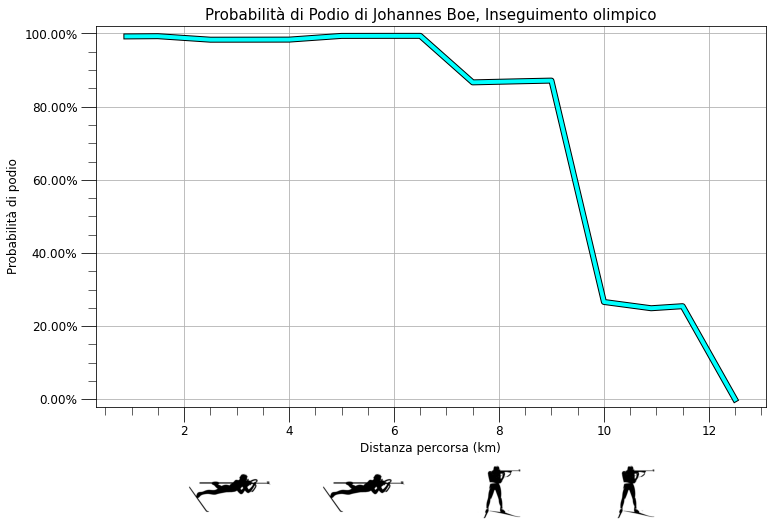

In [18]:
df_Boe = data_df_test_prob[data_df_test_prob.full_name == 'Johannes Thingnes_Boe']
df_collapse_Boe = df_Boe[df_Boe.date_order == 195.0]
fig, ax = plt.subplots(figsize=(12 ,7))
ax.plot(list(df_collapse_Boe['distance']) + [12.5], list(df_collapse_Boe['Podium']) + [0], color = 'aqua', linewidth = 4, zorder = 3, label = 'Johannes Boe')
ax.plot(list(df_collapse_Boe['distance']) + [12.5], list(df_collapse_Boe['Podium']) + [0], color = 'black', linewidth = 6, zorder = 2)
ax.grid(zorder = 1)
ax.set_ylim(-0.02, 1.02)
ax.tick_params(axis='both', which='major', labelsize=12, length=15)
ax.tick_params(axis='both', which='minor', labelsize=12, length=8)
ax.minorticks_on()
ax.set_xlabel('Distanza percorsa (km)', fontsize = 12)
ax.set_ylabel('Probabilità di podio', fontsize = 12)
ax.yaxis.set_major_formatter(formatter)
ax.set_title('Probabilità di Podio di Johannes Boe, Inseguimento olimpico', fontsize = 15)

for i in range(1, 3):
    left, bottom, width, height = ((1 * i)/5) - 0.15/2, -0.3, 0.15, 0.15
    ip = InsetPosition(ax, [left, bottom, width, height])

    new_ax1 = fig.add_axes([0.1, 0.1, 0.1, 0.1], zorder = 4)
    new_ax1.imshow(im)
    new_ax1.set_axes_locator(ip)
    new_ax1.axis('off')


for i in range(3, 5):
    left, bottom, width, height = ((1 * i)/5) - 0.15/2, -0.3, 0.15, 0.15
    ip = InsetPosition(ax, [left, bottom, width, height])

    new_ax1 = fig.add_axes([0.1, 0.1, 0.1, 0.1], zorder = 4)
    new_ax1.imshow(im_stand)
    new_ax1.set_axes_locator(ip)
    new_ax1.axis('off')


plt.show()
#plt.savefig('/Users/tommaso/Desktop/tmp/Boe_Olympics.png', dpi = 300)
#ax.yaxis.set_major_formatter(mtick.PercentFormatter())

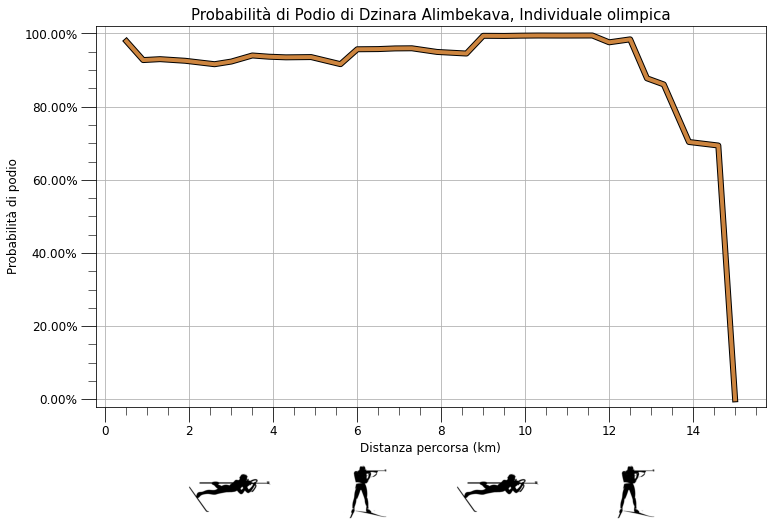

In [19]:
df_Alimbaekava = data_df_test_prob[data_df_test_prob.full_name == 'Dzinara_Alimbekava']
df_collapse_Ali = df_Alimbaekava[df_Alimbaekava.date_order == 191.0]
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(list(df_collapse_Ali['distance']) + [15], list(df_collapse_Ali['Podium']) + [0], color = 'peru', linewidth = 4, zorder = 3, label = 'Johannes Boe')
ax.plot(list(df_collapse_Ali['distance']) + [15], list(df_collapse_Ali['Podium']) + [0], color = 'black', linewidth = 6, zorder = 2)
ax.grid(zorder = 1)
ax.set_ylim(-0.02, 1.02)
ax.tick_params(axis='both', which='major', labelsize=12, length=15)
ax.tick_params(axis='both', which='minor', labelsize=12, length=8)
ax.minorticks_on()
ax.set_xlabel('Distanza percorsa (km)', fontsize = 12)
ax.set_ylabel('Probabilità di podio', fontsize = 12)
ax.yaxis.set_major_formatter(formatter)
ax.set_title('Probabilità di Podio di Dzinara Alimbekava, Individuale olimpica', fontsize = 15)


for i in [1, 3]:
    left, bottom, width, height = ((1 * i)/5) - 0.15/2, -0.3, 0.15, 0.15
    ip = InsetPosition(ax, [left, bottom, width, height])

    new_ax1 = fig.add_axes([0.1, 0.1, 0.1, 0.1], zorder = 4)
    new_ax1.imshow(im)
    new_ax1.set_axes_locator(ip)
    new_ax1.axis('off')


for i in [2, 4]:
    left, bottom, width, height = ((1 * i)/5) - 0.15/2, -0.3, 0.15, 0.15
    ip = InsetPosition(ax, [left, bottom, width, height])

    new_ax1 = fig.add_axes([0.1, 0.1, 0.1, 0.1], zorder = 4)
    new_ax1.imshow(im_stand)
    new_ax1.set_axes_locator(ip)
    new_ax1.axis('off')

plt.show()
#plt.savefig('/Users/tommaso/Desktop/tmp/Ali_Olympics.png', dpi = 300)
#ax.yaxis.set_major_formatter(mtick.PercentFormatter())

In [20]:
data_df_test_prob[data_df_test_prob['Rank'] == 0 ].sort_values(by = 'Victory', ascending = True).head(20)[['full_name', 'position', 'distance', 'Victory']]

,full_name,position,distance,Victory
43060,Quentin_Fillon Maillet,18.0,2.5,0.015933
43115,Quentin_Fillon Maillet,16.0,3.1,0.024338
41165,Alexander_Loginov,73.0,0.3,0.037491
45672,Anton_Babikov,30.0,3.2,0.045673
45768,Anton_Babikov,25.0,3.7,0.049891
43224,Quentin_Fillon Maillet,11.0,5.6,0.053006
43167,Quentin_Fillon Maillet,11.0,5.0,0.053060
43282,Quentin_Fillon Maillet,12.0,6.2,0.061105
45566,Anton_Babikov,25.0,2.7,0.064815
45463,Anton_Babikov,23.0,2.3,0.073050


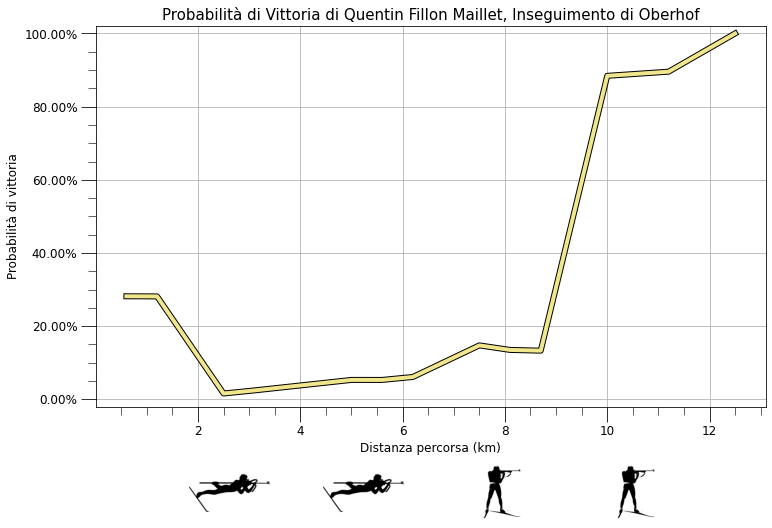

In [21]:
df_FM = data_df_test_prob[data_df_test_prob.full_name == 'Quentin_Fillon Maillet']
df_collapse_FM = df_FM[df_FM.date_order == 183.0]
fig, ax = plt.subplots(figsize=(12 ,7))
ax.plot(list(df_collapse_FM['distance']) + [12.5], list(df_collapse_FM['Victory']) + [1], color = 'khaki', linewidth = 4, zorder = 3, label = 'Quentin_Fillon')
ax.plot(list(df_collapse_FM['distance']) + [12.5], list(df_collapse_FM['Victory']) + [1], color = 'black', linewidth = 6, zorder = 2)
ax.grid(zorder = 1)
ax.set_ylim(-0.02, 1.02)
ax.tick_params(axis='both', which='major', labelsize=12, length=15)
ax.tick_params(axis='both', which='minor', labelsize=12, length=8)
ax.minorticks_on()
ax.set_xlabel('Distanza percorsa (km)', fontsize = 12)
ax.set_ylabel('Probabilità di vittoria', fontsize = 12)
ax.yaxis.set_major_formatter(formatter)
ax.set_title('Probabilità di Vittoria di Quentin Fillon Maillet, Inseguimento di Oberhof', fontsize = 15)

for i in range(1, 3):
    left, bottom, width, height = ((1 * i)/5) - 0.15/2, -0.3, 0.15, 0.15
    ip = InsetPosition(ax, [left, bottom, width, height])

    new_ax1 = fig.add_axes([0.1, 0.1, 0.1, 0.1], zorder = 4)
    new_ax1.imshow(im)
    new_ax1.set_axes_locator(ip)
    new_ax1.axis('off')


for i in range(3, 5):
    left, bottom, width, height = ((1 * i)/5) - 0.15/2, -0.3, 0.15, 0.15
    ip = InsetPosition(ax, [left, bottom, width, height])

    new_ax1 = fig.add_axes([0.1, 0.1, 0.1, 0.1], zorder = 4)
    new_ax1.imshow(im_stand)
    new_ax1.set_axes_locator(ip)
    new_ax1.axis('off')

plt.show()
#plt.savefig('/Users/tommaso/Desktop/tmp/Maillet_Oberhof.png', dpi = 300)
#ax.yaxis.set_major_formatter(mtick.PercentFormatter())

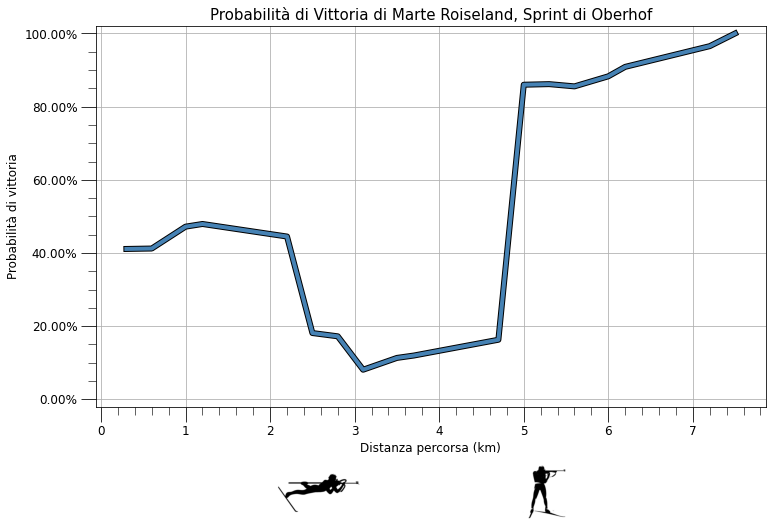

In [22]:
df_MR = data_df_test_prob[data_df_test_prob.full_name == 'Marte Olsbu_Roeiseland']
df_collapse_MR = df_MR[df_MR.date_order == 182.0]
fig, ax = plt.subplots(figsize=(12 ,7))
ax.plot(list(df_collapse_MR['distance']) + [7.5], list(df_collapse_MR['Victory']) + [1], color = 'steelblue', linewidth = 4, zorder = 3, label = 'Quentin_Fillon')
ax.plot(list(df_collapse_MR['distance']) + [7.5], list(df_collapse_MR['Victory']) + [1], color = 'black', linewidth = 6, zorder = 2)
ax.grid(zorder = 1)
ax.set_ylim(-0.02, 1.02)
ax.tick_params(axis='both', which='major', labelsize=12, length=15)
ax.tick_params(axis='both', which='minor', labelsize=12, length=8)
ax.minorticks_on()
ax.set_xlabel('Distanza percorsa (km)', fontsize = 12)
ax.set_ylabel('Probabilità di vittoria', fontsize = 12)
ax.yaxis.set_major_formatter(formatter)
ax.set_title('Probabilità di Vittoria di Marte Roiseland, Sprint di Oberhof', fontsize = 15)


left, bottom, width, height = ((1 * 1)/3) - 0.15/2, -0.3, 0.15, 0.15
ip = InsetPosition(ax, [left, bottom, width, height])

new_ax1 = fig.add_axes([0.1, 0.1, 0.1, 0.1], zorder = 4)
new_ax1.imshow(im)
new_ax1.set_axes_locator(ip)
new_ax1.axis('off')



left, bottom, width, height = ((1 * 2)/3) - 0.15/2, -0.3, 0.15, 0.15
ip = InsetPosition(ax, [left, bottom, width, height])

new_ax1 = fig.add_axes([0.1, 0.1, 0.1, 0.1], zorder = 4)
new_ax1.imshow(im_stand)
new_ax1.set_axes_locator(ip)
new_ax1.axis('off')

plt.show()
#plt.savefig('/Users/tommaso/Desktop/tmp/Roiseland_Oberhof.png', dpi = 300)
#ax.yaxis.set_major_formatter(mtick.PercentFormatter())

In [23]:
data_df_test_prob[data_df_test_prob['Rank'] == 1 ].sort_values(by = 'Podium', ascending = True).head(20).position

15538    18.0
25630    50.0
11384    44.0
25701    36.0
25783    33.0
11479    36.0
11282    45.0
15595    17.0
22997     8.0
25539    44.0
22780    15.0
11578    32.0
11679    30.0
11780    28.0
14895    31.0
15807    12.0
54059    34.0
45284    18.0
15917    11.0
54136    30.0
Name: position, dtype: float64

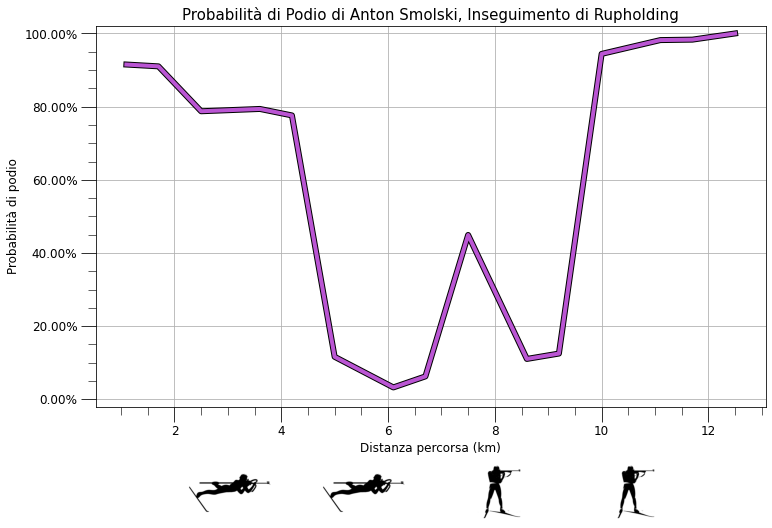

In [24]:
df_SM = data_df_test_prob[data_df_test_prob.full_name == 'Anton_Smolski']
df_collapse_SM = df_SM[df_SM.date_order == 186.0]

fig, ax = plt.subplots(figsize=(12 ,7))

idx = np.argsort(list(df_collapse_SM['distance']) + [12.5])

ax.plot(np.array(list(df_collapse_SM['distance']) + [12.5])[idx], np.array(list(df_collapse_SM['Podium']) + [1])[idx], color = 'mediumorchid', linewidth = 4, zorder = 3, label = 'Anton_Smolski')
ax.plot(np.array(list(df_collapse_SM['distance']) + [12.5])[idx], np.array(list(df_collapse_SM['Podium']) + [1])[idx], color = 'black', linewidth = 6, zorder = 2)

ax.grid(zorder = 1)
ax.set_ylim(-0.02, 1.02)
ax.tick_params(axis='both', which='major', labelsize=12, length=15)
ax.tick_params(axis='both', which='minor', labelsize=12, length=8)
ax.minorticks_on()
ax.set_xlabel('Distanza percorsa (km)', fontsize = 12)
ax.set_ylabel('Probabilità di podio', fontsize = 12)
ax.yaxis.set_major_formatter(formatter)
ax.set_title('Probabilità di Podio di Anton Smolski, Inseguimento di Rupholding', fontsize = 15)


for i in range(1, 3):
    left, bottom, width, height = ((1 * i)/5) - 0.15/2, -0.3, 0.15, 0.15
    ip = InsetPosition(ax, [left, bottom, width, height])

    new_ax1 = fig.add_axes([0.1, 0.1, 0.1, 0.1], zorder = 4)
    new_ax1.imshow(im)
    new_ax1.set_axes_locator(ip)
    new_ax1.axis('off')


for i in range(3, 5):
    left, bottom, width, height = ((1 * i)/5) - 0.15/2, -0.3, 0.15, 0.15
    ip = InsetPosition(ax, [left, bottom, width, height])

    new_ax1 = fig.add_axes([0.1, 0.1, 0.1, 0.1], zorder = 4)
    new_ax1.imshow(im_stand)
    new_ax1.set_axes_locator(ip)
    new_ax1.axis('off')


plt.show()
#plt.savefig('/Users/tommaso/Desktop/tmp/Knotten_Sola.png', dpi = 300)
#ax.yaxis.set_major_formatter(mtick.PercentFormatter())

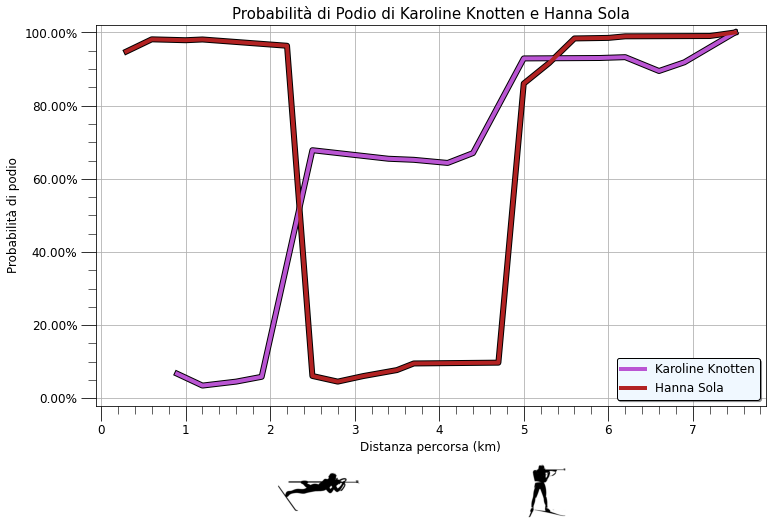

In [25]:
df_Knotten = data_df_test_prob[data_df_test_prob.full_name == 'Karoline Offigstad_Knotten']
df_collapse_Kn = df_Knotten[df_Knotten.date_order == 200.0]
df_Hanna = data_df_test_prob[data_df_test_prob.full_name == 'Hanna_Sola']
df_collapse_HS = df_Hanna[df_Hanna.date_order == 182.0]
fig, ax = plt.subplots(figsize=(12 ,7))

ax.plot(np.array(list(df_collapse_Kn['distance']) + [7.5]), np.array(list(df_collapse_Kn['Podium']) + [1]), color = 'mediumorchid', linewidth = 4, zorder = 3, label = 'Karoline Knotten')
ax.plot(np.array(list(df_collapse_Kn['distance']) + [7.5]), np.array(list(df_collapse_Kn['Podium']) + [1]), color = 'black', linewidth = 6, zorder = 2)
ax.plot(np.array(list(df_collapse_HS['distance']) + [7.5]), np.array(list(df_collapse_HS['Podium']) + [1]), color = 'firebrick', linewidth = 4, zorder = 3, label = 'Hanna Sola')
ax.plot(np.array(list(df_collapse_HS['distance']) + [7.5]), np.array(list(df_collapse_HS['Podium']) + [1]), color = 'black', linewidth = 6, zorder = 2)
ax.grid(zorder = 1)
ax.set_ylim(-0.02, 1.02)
ax.tick_params(axis='both', which='major', labelsize=12, length=15)
ax.tick_params(axis='both', which='minor', labelsize=12, length=8)
ax.minorticks_on()
ax.set_xlabel('Distanza percorsa (km)', fontsize = 12)
ax.set_ylabel('Probabilità di podio', fontsize = 12)
ax.yaxis.set_major_formatter(formatter)
ax.set_title('Probabilità di Podio di Karoline Knotten e Hanna Sola', fontsize = 15)
ax.legend(fontsize = 12, facecolor = 'aliceblue', shadow = True, edgecolor = 'black')

left, bottom, width, height = ((1 * 1)/3) - 0.15/2, -0.3, 0.15, 0.15
ip = InsetPosition(ax, [left, bottom, width, height])

new_ax1 = fig.add_axes([0.1, 0.1, 0.1, 0.1], zorder = 4)
new_ax1.imshow(im)
new_ax1.set_axes_locator(ip)
new_ax1.axis('off')



left, bottom, width, height = ((1 * 2)/3) - 0.15/2, -0.3, 0.15, 0.15
ip = InsetPosition(ax, [left, bottom, width, height])

new_ax1 = fig.add_axes([0.1, 0.1, 0.1, 0.1], zorder = 4)
new_ax1.imshow(im_stand)
new_ax1.set_axes_locator(ip)
new_ax1.axis('off')

plt.show()
#plt.savefig('/Users/tommaso/Desktop/tmp/Knotten_Sola.png', dpi = 300)
#ax.yaxis.set_major_formatter(mtick.PercentFormatter())

In [26]:
10/19

0.5263157894736842

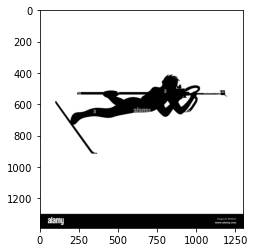

In [27]:
prone = cv2.imread('../../../prone_position.jpeg')
prone_gs = cv2.cvtColor(prone, cv2.COLOR_BGR2GRAY)
plt.imshow(prone_gs, cmap = 'gray')

In [28]:
def cv_tresholding(img, threshold):
    img = img.copy()
    img = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)[1]
    return img

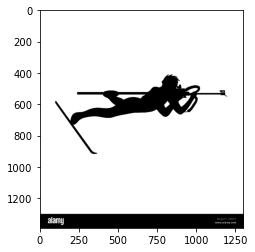

In [29]:
thresholded_prone = cv_tresholding(prone_gs, 200)
height, width = thresholded_prone.shape
plt.imshow(thresholded_prone, cmap = 'gray')


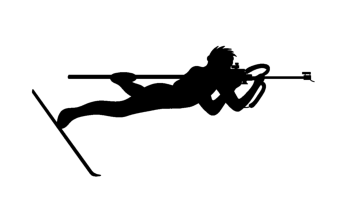

In [30]:

# Crop image
thresholded_prone_cropped = thresholded_prone[0: width, :]
height, width = thresholded_prone_cropped.shape
thresholded_prone_cropped = thresholded_prone[int(height * 0.2) : int(height * 0.8), int(width * 0) : int(width * 1)]
thresholded_prone_cropped.shape
plt.imshow(thresholded_prone_cropped, cmap = 'gray')
plt.axis('off')
plt.savefig('/Users/tommaso/Desktop/BiathlonAzzurroWrapper/prone.png', bbox_inches = 'tight', pad_inches = 0)


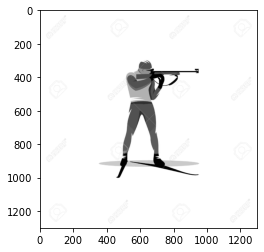

In [31]:
standing = cv2.imread('../../../standing.jpeg')
standing_gs = cv2.cvtColor(standing, cv2.COLOR_BGR2GRAY)
plt.imshow(standing_gs, cmap = 'gray')

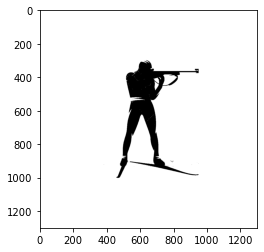

In [32]:
thresholded_standing = cv_tresholding(standing_gs, 190)
height, width = thresholded_standing.shape
plt.imshow(thresholded_standing, cmap = 'gray')


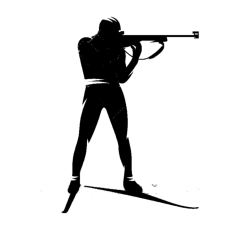

In [33]:

# Crop image
thresholded_standing_cropped = thresholded_standing[0: width, :]
height, width = thresholded_standing_cropped.shape
thresholded_standing_cropped = thresholded_standing_cropped[int(height * 0.2) : int(height * 0.8), int(width * 0.2) : int(width * 0.8)]
thresholded_standing_cropped.shape
plt.imshow(thresholded_standing_cropped, cmap = 'gray')
plt.axis('off')
plt.savefig('/Users/tommaso/Desktop/BiathlonAzzurroWrapper/standing.png', bbox_inches = 'tight', pad_inches = 0)


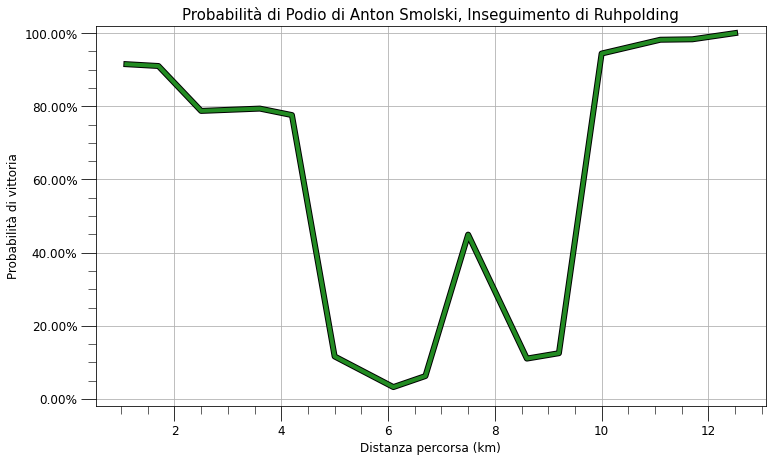

In [34]:
df_Smolski = data_df_test_prob[data_df_test_prob.full_name == 'Anton_Smolski']
df_collapse_Sm = df_Smolski[df_Smolski.date_order == 186.0]
fig, ax = plt.subplots(figsize=(12 ,7))
idx = np.argsort(list(df_collapse_Sm['distance']) + [12.5])
ax.plot(np.array(list(df_collapse_Sm['distance']) + [12.5])[idx], np.array(list(df_collapse_Sm['Podium']) + [1])[idx], color = 'forestgreen', linewidth = 4, zorder = 3, label = 'Quentin_Fillon')
ax.plot(np.array(list(df_collapse_Sm['distance']) + [12.5])[idx], np.array(list(df_collapse_Sm['Podium']) + [1])[idx], color = 'black', linewidth = 6, zorder = 2, label = 'Quentin_Fillon')
ax.grid(zorder = 1)
ax.set_ylim(-0.02, 1.02)
ax.tick_params(axis='both', which='major', labelsize=12, length=15)
ax.tick_params(axis='both', which='minor', labelsize=12, length=8)
ax.minorticks_on()
ax.set_xlabel('Distanza percorsa (km)', fontsize = 12)
ax.set_ylabel('Probabilità di vittoria', fontsize = 12)
ax.yaxis.set_major_formatter(formatter)
ax.set_title('Probabilità di Podio di Anton Smolski, Inseguimento di Ruhpolding', fontsize = 15)

plt.show()
#ax.yaxis.set_major_formatter(mtick.PercentFormatter())